In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
import mpmath as mp
from math import sqrt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

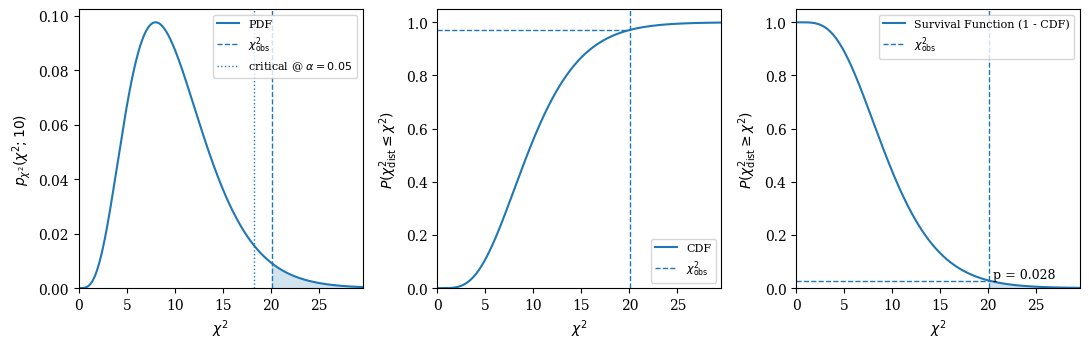

In [ ]:
df = 10  # degrees of freedom (ν)
alpha = 0.05  # significance level
x_obs = 20.1  # example observed chi-square statistic

x_max = chi2.ppf(0.999, df)
x = np.linspace(0, x_max, 1200)

pdf = chi2.pdf(x, df)
cdf = chi2.cdf(x, df)
sf  = chi2.sf(x, df)

x_crit = chi2.ppf(1 - alpha, df)
p_value = chi2.sf(x_obs, df)

fig, axes = plt.subplots(1, 3, figsize=(11, 3.6), sharex=False, sharey=False)

# pdf
ax = axes[0]
ax.plot(x, pdf, label="PDF")
mask = x >= x_obs
ax.fill_between(x[mask], pdf[mask], 0, alpha=0.2)
ax.axvline(x_obs, linestyle="--", linewidth=1, label=r"$\chi^2_{\mathrm{obs}}$")
ax.axvline(x_crit, linestyle=":",  linewidth=1, label=fr"critical @ $\alpha={alpha}$")
ax.set_xlabel(r"$\chi^2$")
ax.set_ylabel(r"$p_{\chi^2}(\chi^2; 10)$")
ax.legend(frameon=True, fontsize=8)
ax.set_xlim(0, x_max)
ax.set_ylim(bottom=0)

# cdf
ax = axes[1]
ax.plot(x, cdf, label="CDF")
y_cdf_obs = chi2.cdf(x_obs, df)
ax.axvline(x_obs, linestyle="--", linewidth=1, label=r"$\chi^2_{\mathrm{obs}}$")
ax.axhline(y_cdf_obs, xmin=0, xmax=(x_obs - 0) / (x_max - 0), linestyle="--", linewidth=1)
ax.set_xlabel(r"$\chi^2$")
ax.set_ylabel(r"$P(\chi^2_{\text{dist}} \, ≤ \, \chi^2)$")
ax.legend(frameon=True, fontsize=8, loc="lower right")
ax.set_xlim(0, x_max)
ax.set_ylim(0, 1.05)

# survival function
ax = axes[2]
ax.plot(x, sf, label="Survival Function (1 - CDF)")
y_sf_obs = chi2.sf(x_obs, df)
ax.axvline(x_obs, linestyle="--", linewidth=1, label=r"$\chi^2_{\mathrm{obs}}$")
ax.axhline(y_sf_obs, xmin=0, xmax=(x_obs - 0) / (x_max - 0), linestyle="--", linewidth=1)
mask = x >= x_obs
ax.fill_between(x[mask], sf[mask], 0, alpha=0.2)
ax.text(x_obs, y_sf_obs, f" p = {p_value:.3f}", va="bottom", ha="left", fontsize=9)
ax.set_xlabel(r"$\chi^2$")
ax.set_ylabel(r"$P(\chi^2_{\text{dist}}\, ≥ \, \chi^2)$")
ax.legend(frameon=True, fontsize=8, loc="upper right")
ax.set_xlim(0, x_max)
ax.set_ylim(0, 1.05)


plt.tight_layout()
plt.savefig("../../../figs/models-vs-data/chi_square.pdf")
plt.show()

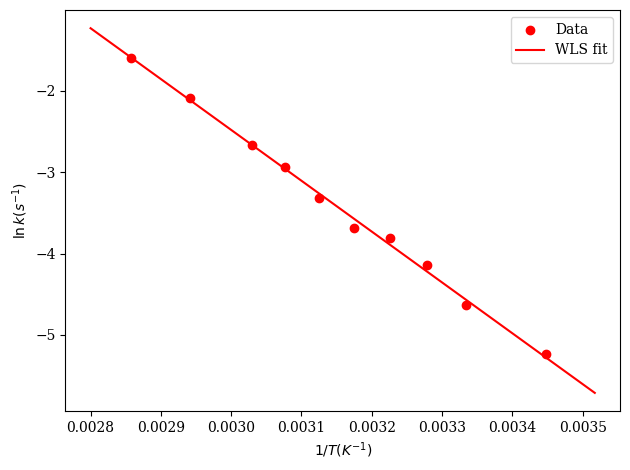

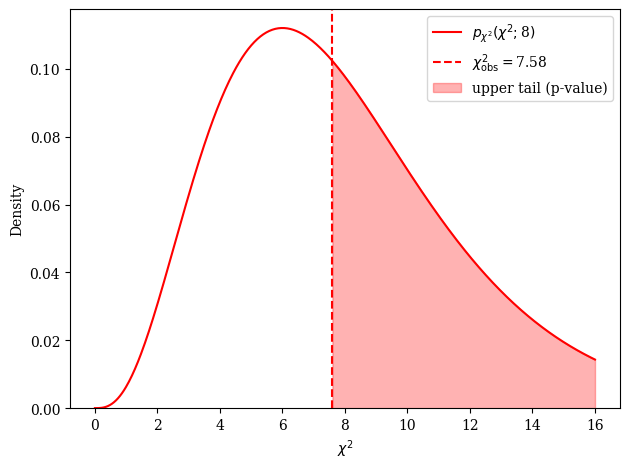

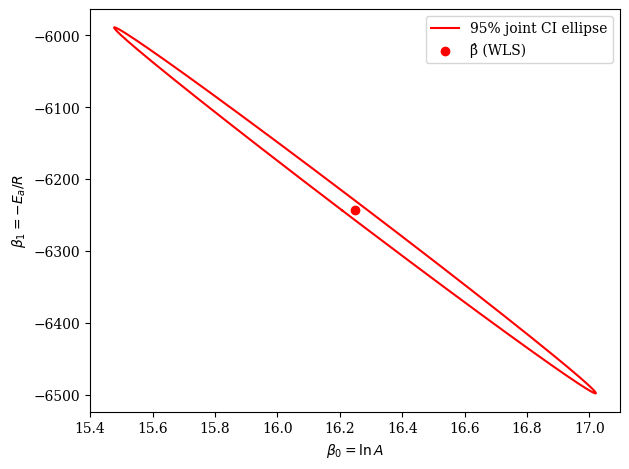

In [ ]:
# simulate data
rng = np.random.default_rng(42)
R = 8.31446261815324  # J/(mol*K)
Ea_true = 52e3  # J/mol
A_true = 1.2e7 # s^-1

T = np.array([290, 300, 305, 310, 315, 320, 325, 330, 340, 350], dtype=float)
x = 1.0 / T
y_true = np.log(A_true) - Ea_true / R * x

sigma_y = 0.03 + 0.07 * (x - x.min()) / (x.max() - x.min())
y_obs = y_true + rng.normal(0.0, 1.0, size=T.size) * sigma_y

# WLS
N = T.size
X = np.column_stack([np.ones(N), x])
w = 1.0 / (sigma_y**2)
XTWX = X.T @ (w[:, None] * X)
XTWy = X.T @ (w * y_obs)
beta_hat = np.linalg.solve(XTWX, XTWy)
beta0_hat, beta1_hat = beta_hat
y_fit = X @ beta_hat
residuals = y_obs - y_fit
chi2_obs = float(np.sum((residuals**2) * w))
n_params = 2
nu = N - n_params
chi2_red = chi2_obs / nu
p_value = float(mp.gammainc(nu/2, chi2_obs/2, mp.inf) / mp.gamma(nu/2))

V_beta = np.linalg.inv(XTWX)
se_beta0 = sqrt(V_beta[0, 0])
se_beta1 = sqrt(V_beta[1, 1])

Ea_hat = -R * beta1_hat
A_hat = np.exp(beta0_hat)
J_transform = np.array([[1.0, 0.0],
                        [0.0, -R]])
V_transformed = J_transform @ V_beta @ J_transform.T
se_lnA = sqrt(V_transformed[0, 0])
se_Ea = sqrt(V_transformed[1, 1])
se_A = A_hat * se_lnA

delta_chi2_1param_95 = 3.84
z_approx = sqrt(delta_chi2_1param_95)
ci_beta0 = (beta0_hat - z_approx * se_beta0, beta0_hat + z_approx * se_beta0)
ci_beta1 = (beta1_hat - z_approx * se_beta1, beta1_hat + z_approx * se_beta1)
ci_lnA = (np.log(A_hat) - z_approx * se_lnA, np.log(A_hat) + z_approx * se_lnA)
ci_A = (np.exp(ci_lnA[0]), np.exp(ci_lnA[1]))
ci_Ea = (Ea_hat - z_approx * se_Ea, Ea_hat + z_approx * se_Ea)
delta_chi2_joint2_95 = 5.99


# plotting
fig1 = plt.figure()
plt.scatter(x, y_obs, label="Data", color="red")
x_line = np.linspace(x.min()*0.98, x.max()*1.02, 200)
y_line = beta0_hat + beta1_hat * x_line
plt.plot(x_line, y_line, label="WLS fit", color="red")
plt.xlabel(r"$1 / T (K^{-1})$")
plt.ylabel(r"$\ln k (s^{-1})$")
# plt.title("Arrhenius plot with weighted linear fit")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("../../../figs/models-vs-data/arrhenius_plot.pdf", bbox_inches="tight", transparent=True)
plt.show()


fig2 = plt.figure()
xx = np.linspace(0.0, max(chi2_obs*1.5, 2*nu), 500)
def chi2_pdf(x, nu):
    return (x**(nu/2 - 1) * np.exp(-x/2)) / (2**(nu/2) * mp.gamma(nu/2))
pdf_vals = np.array([chi2_pdf(val, nu) for val in xx], dtype=float)
plt.plot(xx, pdf_vals, label=r"$p_{\chi^2}(\chi^2;$" + f"{nu}$)$", color="red")
plt.axvline(chi2_obs, linestyle="--", label=r"$\chi^2_{\mathrm{obs}} = $" + f"{chi2_obs:.2f}", color="red")
mask = xx >= chi2_obs
plt.fill_between(xx[mask], pdf_vals[mask], alpha=0.3, label="upper tail (p-value)", color="red")
plt.xlabel(r"$\chi^2$")
plt.ylim(bottom=0)
plt.ylabel("Density")
# plt.title("Chi-square distribution and upper-tail p-value")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("../../../figs/models-vs-data/chi2_tail.pdf", bbox_inches="tight", transparent=True)
plt.show()


fig3 = plt.figure()
eigvals, eigvecs = np.linalg.eigh(V_beta)
theta = np.linspace(0, 2*np.pi, 400)
r = np.sqrt(delta_chi2_joint2_95 * eigvals)
ellipse_pts = (eigvecs @ (r[:, None] * np.vstack([np.cos(theta), np.sin(theta)]))).T + beta_hat
plt.plot(ellipse_pts[:, 0], ellipse_pts[:, 1], label="95% joint CI ellipse", color="red")
plt.scatter([beta0_hat], [beta1_hat], label="β̂ (WLS)", color="red")
plt.xlabel(r"$\beta_0 = \ln A$")
plt.ylabel(r"$\beta_1 = -E_a/R$")
# plt.title("Joint 95% confidence region in parameter space")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("../../../figs/models-vs-data/beta_joint_ellipse.pdf", bbox_inches="tight", transparent=True)
plt.show()